# 3. Time-Series

Working with time-series data often has some unique graphs. It made sense to break this into a small section by itself to explore the interactions with time-series.

In particular, time-series data can sometimes be the most difficult to work with, and fluency with handling date objects will come in handy.

There are a number of objects which are primarily found in **NumPy** that concern time-series:
- DateTimeIndex
- PeriodIndex
- TimeDeltaIndex

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas.plotting as pplt
import numpy as np
%matplotlib inline

We will begin with some cumulative randomly distributed values to demonstrate:

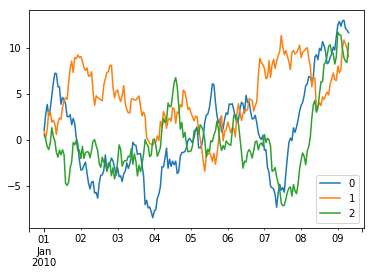

In [2]:
N=200
np.random.seed(19680801)
x = pd.DataFrame(np.random.randn(N,3).cumsum(0), index=pd.date_range("1/1/2010", periods=N, freq="H"))
x.plot()
plt.show()

It's worth mentioning that default Matplotlib is absolutely awful at plotting the x axis (i.e using **plt.plot**).

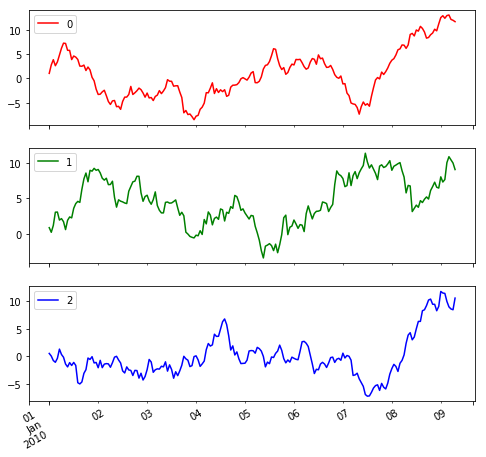

In [3]:
x.plot(subplots=True, figsize=(8,8), color=['r','g','b'])
plt.show()

### Time-Deltas

Often we may be interested in data which *changes* with respect to time:

In [4]:
y = pd.Series(np.random.randn(200), index=pd.to_timedelta(np.arange(200), "H"))
y.head()

00:00:00    1.395356
01:00:00    1.882150
02:00:00    0.029296
03:00:00   -0.378227
04:00:00    1.431568
dtype: float64

We can also obtain a delta by subtracting together two timeseries datasets:

In [5]:
pd.date_range("1/1/2015", periods=20) - pd.date_range("1/6/2015", periods=20, freq="H")

TimedeltaIndex(['-5 days +00:00:00', '-5 days +23:00:00', '-4 days +22:00:00',
                '-3 days +21:00:00', '-2 days +20:00:00', '-1 days +19:00:00',
                  '0 days 18:00:00',   '1 days 17:00:00',   '2 days 16:00:00',
                  '3 days 15:00:00',   '4 days 14:00:00',   '5 days 13:00:00',
                  '6 days 12:00:00',   '7 days 11:00:00',   '8 days 10:00:00',
                  '9 days 09:00:00',  '10 days 08:00:00',  '11 days 07:00:00',
                 '12 days 06:00:00',  '13 days 05:00:00'],
               dtype='timedelta64[ns]', freq=None)

### Time Frequencies and Offsets

Fundamental to these Pandas time series tools is the concept of a frequency or date offset. We can use such codes to specify any desired frequency spacing:

- **D**: Calendar Day
- **W**: weekly
- **M**: month end
- **Q**: quarter end
- **A**: year end
- **H**: hours
- **T**: minutes
- **S**: seconds
- **L**: milliseconds
- **U**: microseconds
- **N**: nanoseconds
- **B**: business day
- **BM**: business month end
- **BQ**: business quarter
- **BA**: business year end
- **BH**: business hours

In [6]:
pd.timedelta_range(0, periods=9, freq="H")

TimedeltaIndex(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
                '05:00:00', '06:00:00', '07:00:00', '08:00:00'],
               dtype='timedelta64[ns]', freq='H')

In [7]:
pd.timedelta_range(0, periods=9, freq="U")

TimedeltaIndex([       '00:00:00', '00:00:00.000001', '00:00:00.000002',
                '00:00:00.000003', '00:00:00.000004', '00:00:00.000005',
                '00:00:00.000006', '00:00:00.000007', '00:00:00.000008'],
               dtype='timedelta64[ns]', freq='U')

In [8]:
pd.timedelta_range(0, periods=9, freq="10S")

TimedeltaIndex(['00:00:00', '00:00:10', '00:00:20', '00:00:30', '00:00:40',
                '00:00:50', '00:01:00', '00:01:10', '00:01:20'],
               dtype='timedelta64[ns]', freq='10S')

In [9]:
pd.date_range(0, periods=9, freq="3D")

DatetimeIndex(['1970-01-01', '1970-01-04', '1970-01-07', '1970-01-10',
               '1970-01-13', '1970-01-16', '1970-01-19', '1970-01-22',
               '1970-01-25'],
              dtype='datetime64[ns]', freq='3D')

In [10]:
pd.timedelta_range(0, periods=9, freq="2H30T")

TimedeltaIndex(['00:00:00', '02:30:00', '05:00:00', '07:30:00', '10:00:00',
                '12:30:00', '15:00:00', '17:30:00', '20:00:00'],
               dtype='timedelta64[ns]', freq='150T')

### Interpolation

In time-series analysis we could often be handling data with a small number of *missing values*. Assuming the frequency of our time-series is appropriately small, we could interpolate missing values using a *linear* or *quadratic* interpolator:

450 500


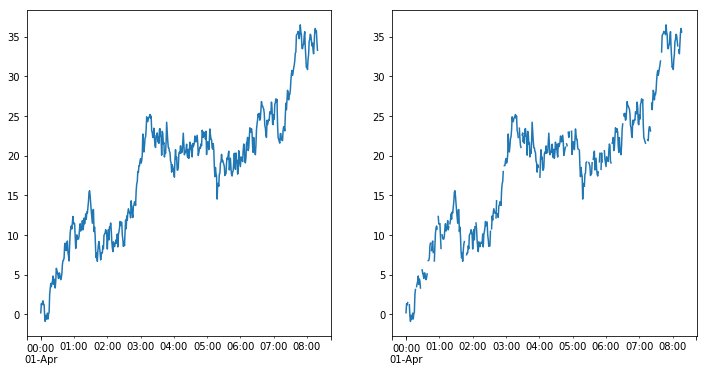

In [11]:
np.random.seed(153446)
N=500
z = pd.Series(np.random.randn(N).cumsum(), index=pd.date_range("4/1/2018", periods=N, freq="T"))
zn = z.where(np.random.choice([0,1], len(z), p=[.1, .9]) == 1)
print(zn.count(), zn.interpolate().count())

fig,ax=plt.subplots(ncols=2, figsize=(12,6))
z.plot(ax=ax[0], label="original")
zn.plot(ax=ax[1], label="loss")
plt.show()

With a linear or other interpolator, this data shouldn't be too far from it's original, we can check this by subtracting the interpolated value from the real exact value:

In [15]:
zn_int = [zn.interpolate(method='linear'), zn.interpolate(method='quadratic'), zn.interpolate(method='nearest'),
         zn.interpolate(method='cubic')]

fig,ax=plt.subplots(ncols=4, nrows=2, figsize=(16,6))
import scipy

for i,interp in enumerate(zn_int):
    interp.plot(ax=ax[0,i])
    interp.sub(z).plot(ax=ax[1,i])
    print("i={}, MSE={:0.4f}".format(i, interp.sub(z).apply(np.square).mean()))
fig.tight_layout()

ImportError: cubic interpolation requires SciPy

### Resampling/Converting

We've looked at converting frequencies previously as part of the Pandas learning: let's put this to use in some plots:

* **Resampling**: fundamentally *aggregates* the data.
* **Converting**: fundamentally *selects* data points.

Below we resample and convert from a more-to-less frequent sampling:

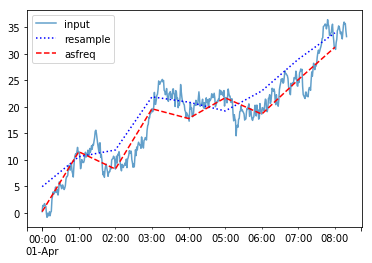

In [16]:
z.plot(alpha=.7, style="-", label="input")
z.resample("H").mean().plot(color='b', style=":", label="resample")
z.asfreq("H").plot(style="--", color='r', label="asfreq")
plt.legend()
plt.show()

In the reverse case, we interpolate missing points from a less-to-more frequent sampling:

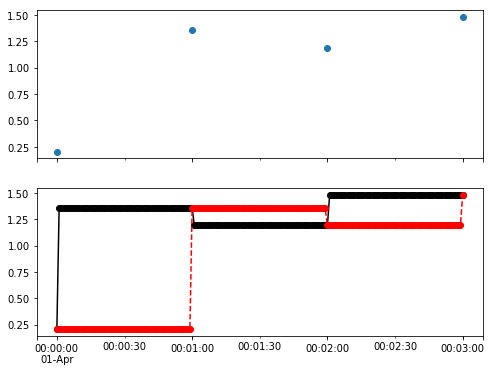

In [17]:
fig,ax=plt.subplots(2, figsize=(8,6), sharex=True)
z[:4].asfreq("S").plot(marker='o', linestyle='-', ax=ax[0])
z[:4].asfreq("S", method='bfill').plot(ax=ax[1], style='o-', c='k')
z[:4].asfreq("S", method='ffill').plot(ax=ax[1], style='o--', c='r')
plt.show()

### Stationarity

A timeseries is said to be **stationary** if its statistical properties such as mean and variance remain *constant* over time. This has important implications to timeseries models when it comes to *forecasting*.

Here is an example of a stationary time-series:

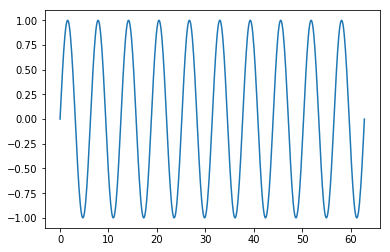

In [18]:
a = np.linspace(0,20*np.pi,500)
y = np.sin(a)
plt.plot(a,y)
plt.show()

Stationarity is defined as:
- constant mean
- constant variance
- an autocovariance that does not depend on time

We can test for stationarity through visual inspection or via the *Dickey-Fuller Test*.

Let's check this using the popular Air Passengers dataset for a flight every month over 12 years.

#Passengers    int64
dtype: object


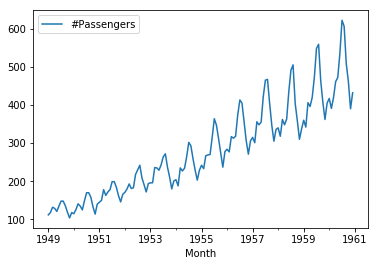

In [19]:
passenger = pd.read_csv("AirPassengers.csv", index_col=0, parse_dates=True)
print(passenger.dtypes)
passenger.plot()
plt.show()

Here we see there is an **overall increasing trend** in the data along with some seasonal variations. We want to *make* the time series stationary, by performing various **transformations** to the data. There are two concepts involved in making data non-stationary:
- Trend; varying mean over time.
- Seasonality; variations at specific time-frames. e.g people may prefer to book a plane flight in the summer months. 

Knowing of these factors, we can attempt to eliminate them from the series to get a returned stationary series. Then statistical forecasting techniques could be implemented on the series. 

### Estimating & Eliminating Trend

One of the tricks we can use is *transformation*, for instance to positive trends we could apply a penalizing term to higher values by taking the $\log$ or square-root.

Here we can see a marked reduction in the variance, but we could use one of the previous methods to remove trends, such as *moving averages* (MA), *smoothing* and *polynomial fitting*.

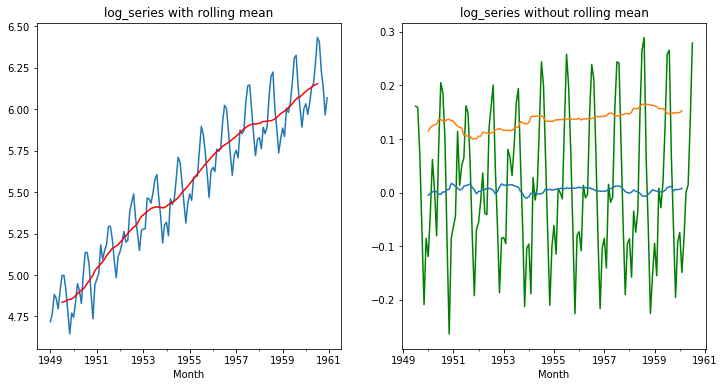

In [20]:
psng_log = passenger.apply(np.log)
psng_ma = psng_log.rolling(12, center=True).mean()
psng_mstd = psng_log.rolling(12, center=True).std()
psng_ma_diff = psng_log - psng_ma

fig,ax=plt.subplots(ncols=2, figsize=(12,6))
psng_log.plot(ax=ax[0], label="input", legend=False)
psng_ma.plot(ax=ax[0], color='r', label="rolling 12", legend=False)
psng_ma_diff.plot(ax=ax[1], color='g', legend=False)
psng_ma_diff.rolling(12, center=True).agg(['mean','std']).plot(ax=ax[1], legend=False)

ax[0].set_title("log_series with rolling mean")
ax[1].set_title("log_series without rolling mean")
plt.show()

This looks considerably better, however one of the primary drawbacks is that the time-period has to be strictly defined.

### Weighted Moving Averages

In this case we can take yearly averages but in complex situations like forecasting a stock price, it is difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

In Pandas this is implemented as:

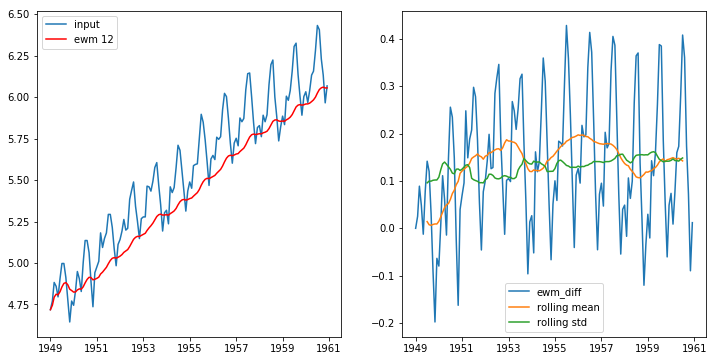

In [21]:
psng_ewm = psng_log.ewm(halflife=12).mean()
psng_ewm_diff = psng_log - psng_ewm

fig,ax=plt.subplots(ncols=2, figsize=(12,6))
ax[0].plot(psng_log, label="input")
ax[0].plot(psng_ewm, label="ewm 12", color='r')
ax[1].plot(psng_ewm_diff, label="ewm_diff")
ax[1].plot(psng_ewm_diff.rolling(12, center=True).mean(), label="rolling mean")
ax[1].plot(psng_ewm_diff.rolling(12, center=True).std(), label="rolling std")
ax[0].legend()
ax[1].legend()
plt.show()

Note here that we use an 'exponential' weighting, with a *halflife* parameter of 12 to define the amount of exponential decay. This is an assumption which depends on business domain, but this goes into complex theories regarding the data you wish to model. 

### Estimating & Eliminating Seasonality

Simple trend reduction techniques don't work in many cases, particularly ones with *high seasonality*. Let's discuss ways of removing seasonality:

1. Differencing - using time lags
2. Decomposition

For instance we could plot the difference between a timeseries and it's shift to eliminate trend and improve stationarity:

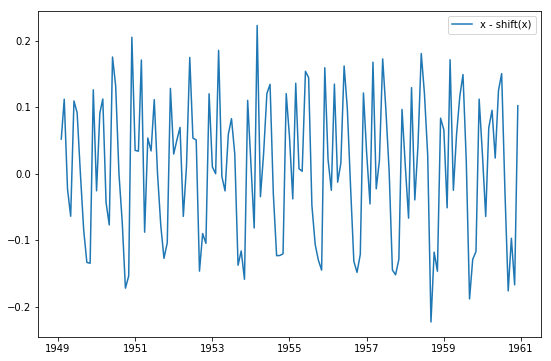

In [22]:
plt.figure(figsize=(9,6))
plt.plot(psng_log - psng_log.shift(), label="x - shift(x)")
plt.legend()
plt.show()

In a **decomposing** approach, both trend and seasonality are modelled separately and the remaining part of the series is returned. 

We can use some powerful statistical functions to calculate this for us:

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(psng_log)

fig,ax=plt.subplots(4, figsize=(8,10))
ax[0].plot(psng_log, label="input", color='k')
ax[1].plot(decomp.trend, label="trend", color='r')
ax[2].plot(decomp.seasonal, label="seasonal", color='g')
ax[3].plot(decomp.resid, label="residual", color='b')
for a in ax:
    a.legend()
plt.show()

ImportError: dlopen(//anaconda/lib/python3.5/site-packages/scipy/special/_ufuncs.cpython-35m-darwin.so, 2): Library not loaded: @rpath/libgfortran.3.dylib
  Referenced from: //anaconda/lib/python3.5/site-packages/scipy/special/_ufuncs.cpython-35m-darwin.so
  Reason: image not found

### Time-Shifts

Another common time series-specific operation is shifting of data in time. Pandas has two closely related methods for computing this: `shift()` and `tshift()` In short, the difference between them is that `shift()` shifts the data, while `tshift()` shifts the index. In both cases, the shift is specified in multiples of the frequency.

Below we shift using each method by 100:

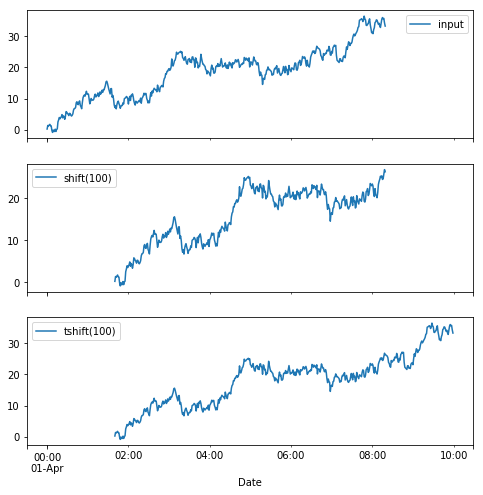

In [24]:
fig,ax=plt.subplots(3, figsize=(8,8), sharex=True)
z.plot(ax=ax[0], label="input")
z.shift(100).plot(ax=ax[1], label="shift(100)")
z.tshift(100).plot(ax=ax[2], label="tshift(100)")
for a in ax:
    a.legend()
    a.set_xlabel("Date")
plt.show()

### Lag-Plot

Lag plots are used to check if a data set or time series is random. Random data should not exhibit any structure in the lag plot. Non-random structure implies that the underlying data are not random. The lag argument may be passed, and when lag=1 the plot is essentially data[:-1] vs. data[1:].

As you see here all we do is shift the timeseries up by 1 (the lag) and 2 and compare to at time $t$.

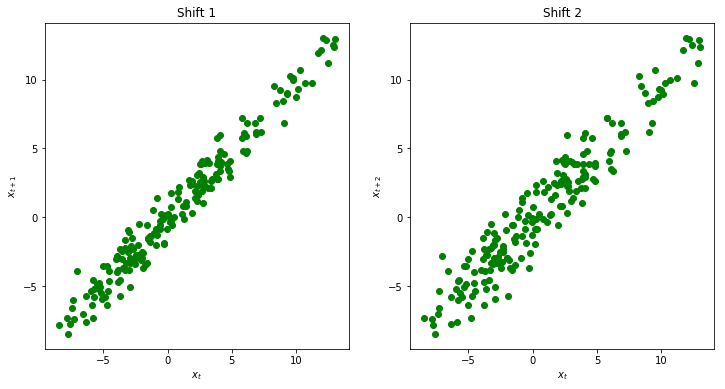

In [25]:
fig,ax=plt.subplots(ncols=2, figsize=(12,6))
for i in range(2):
    ax[i].scatter(x[0], x[0].shift(i+1), c='g')
    ax[i].set_xlabel("$x_t$")
    ax[i].set_ylabel("$x_{t+%d}$" % (i+1))
    ax[i].set_title("Shift %d" % (i+1))

### Autocorrelation and Partial Autocorrelation plot

We saw different techniques and all of them worked reasonably well for making the TS stationary. Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

- A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
- A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

We use two plots to determine these numbers. Lets discuss them first.

- **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
- **Partial Autocorrelation Function (PACF)**: This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.



In [26]:
from statsmodels.tsa.stattools import acf, pacf

def plot_acf(ts, fig, plot_loc):
    lag_acf = acf(ts, nlags=20)
    ax = fig.add_subplot(plot_loc)
    ax.plot(lag_acf)
    ax.axhline(y=0, linestyle="--", color='gray')
    ax.axhline(y=-1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
    ax.axhline(y=1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
    ax.set_title("Aurocorrelation function")
    

def plot_pacf(ts, fig, plot_loc):
    lag_pacf = pacf(ts, nlags=20, method='ols')
    ax = fig.add_subplot(plot_loc)
    ax.plot(lag_pacf)
    ax.axhline(y=0, linestyle="--", color='gray')
    ax.axhline(y=-1.96/np.sqrt(len(lag_pacf)),linestyle='--',color='gray')
    ax.axhline(y=1.96/np.sqrt(len(lag_pacf)),linestyle='--',color='gray')
    ax.set_title("Partial Aurocorrelation function")
    
    
fig = plt.figure(figsize=(12,6))
    
plot_acf((psng_log - psng_log.shift()).dropna(), fig, 121)
plot_pacf((psng_log - psng_log.shift()).dropna(), fig, 122)

ImportError: dlopen(//anaconda/lib/python3.5/site-packages/scipy/special/_ufuncs.cpython-35m-darwin.so, 2): Library not loaded: @rpath/libgfortran.3.dylib
  Referenced from: //anaconda/lib/python3.5/site-packages/scipy/special/_ufuncs.cpython-35m-darwin.so
  Reason: image not found

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. We are interested in where the line passes the first confidence interval as this is the number of parameters to take with respect to autoregression (ACF) and moving average (PACF).

# Tasks

**RAINFALL**

We're going to be working with some national weather data from the area of *Nashville* from the [United States](https://w2.weather.gov/climate/index.php?wfo=ohx). 

This data records the amount of rainfall dating back to 1871, every month.

In [27]:
rain = pd.read_table("nashville_precip.txt")
rain.head(1)

Year   Jan   Feb   Mar   Apr  May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
0  1871  2.76  4.58  5.01  4.13  3.3  2.98  1.58  2.36  0.95  1.31  2.13  1.65

In [28]:
rain.tail(1)

Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug  Sep   Oct   Nov  \
140  2011  2.31  5.54  4.59  7.51  4.38  5.04  3.46  1.78  6.2  0.93  6.15   

      Dec  
140  4.25

### Preprocessing

We need to convert this data where rows represent the month, with a datetime object as the index, with rainfall as our variable of interest. 

In [29]:
# create datetimeindex using start and end, using month frequency
ts = pd.date_range("1/1/1871", "1/1/2012", freq="M")
ts.shape

(1692,)

Now let's convert rainfall to long-form series and set the new index.

In [30]:
# drop year, melt columns and set index.
long_rain = (rain.drop("Year", axis=1).melt(var_name="month", value_name="rainfall")
                 .set_index(ts).rainfall.astype(np.float))
long_rain.head()

1871-01-31    2.76
1871-02-28    2.32
1871-03-31    2.96
1871-04-30    5.22
1871-05-31    6.15
Freq: M, Name: rainfall, dtype: float64

Let's quickly visualise a portion of our data to see what it looks like:

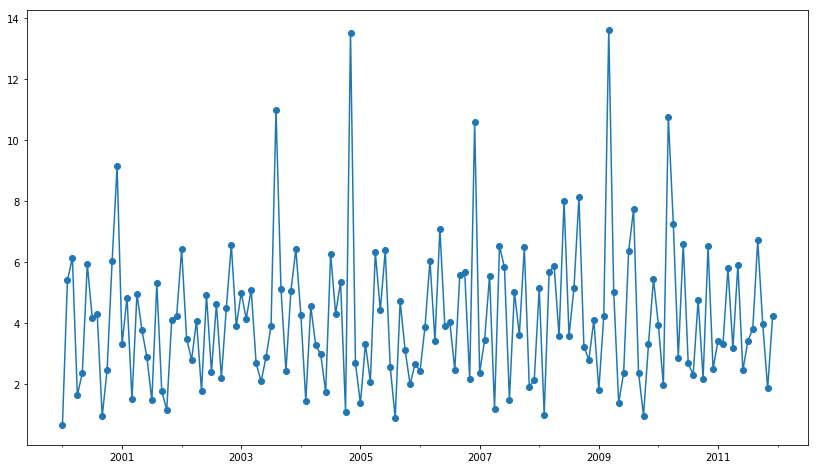

In [31]:
long_rain["2000":].plot(figsize=(14,8), marker='o')
plt.show()

### Task 1.

In order to make the data more readable, resample it into years, taking the *median* value to reduce outlier skew.

Plot this resampled data against time between 1920 to 1960. Ensure to label all axes and title.

In [ ]:
# your codes here

### Task 2.

Remove the trend/seasonality from the dataset. This can be achieved in a number of ways, but the easiest would be by *differencing*.

Plot the monthly rainfall, next to the 'differenced rainfall' with a rolling mean and standard deviation with $w=30$, in row-wise fashion.

In [ ]:
# your codes here

### Task 3.

Calculate an *exponential weighted moving average* for the *yearly rainfall* and plot this with the original data, alongside a plot with the EMWA removed, alongside the rolling mean and standard deviation. How well does it do?

In [ ]:
# your codes here

### Task 4.

Perform seasonal analysis on the monthly data between **2000**-**present** and output the 4 plots as shown previously. Use one of the previous methods as input (whichever you think is closest to a stationary series). How much of this data can be broken down into trend and seasonality? Which year has the most unpredicted changes in rainfall?

In [ ]:
#your codes here